In [63]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sqlalchemy import create_engine

In [ ]:
# Load all stock CSVs
csv_dir = r"E:\StockAnalysis\Project\output_csvs_combined" 
csv_files = glob(os.path.join(csv_dir, "*.csv"))

In [3]:
# Combine all CSVs into a single DataFrame
combined_df = pd.concat([
    pd.read_csv(file).assign(Ticker=os.path.basename(file).replace(".csv", "")) for file in csv_files
])


In [ ]:
# Preprocess
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df.sort_values(by=['Ticker', 'date'], inplace=True)

In [ ]:
# Calculate daily return
combined_df['daily_return'] = combined_df.groupby('Ticker')['close'].pct_change()

In [ ]:
# Calculate volatility (standard deviation of daily returns)
volatility_df = combined_df.groupby('Ticker')['daily_return'].std().reset_index()
volatility_df.columns = ['Ticker', 'Volatility']
volatility_df.sort_values(by='Volatility', ascending=False, inplace=True)

In [ ]:
# Calculate cumulative return
combined_df['cumulative_return'] = combined_df.groupby('Ticker')['daily_return'].cumsum()

In [ ]:
# Select top 10 most volatile stocks
top_10_volatility_df = volatility_df.head(10)

In [ ]:
# Identify top 5 stocks by cumulative return (last value)
final_returns = combined_df.groupby('Ticker')['cumulative_return'].last().sort_values(ascending=False)
top_5_tickers = final_returns.head(5).index.tolist()

In [ ]:
# Filter data for top 5
top_5_df = combined_df[combined_df['Ticker'].isin(top_5_tickers)][['date', 'Ticker', 'cumulative_return']]

In [ ]:
# Save the results
output_dir = r"E:\StockAnalysis\Project\analysis_results_new"
os.makedirs(output_dir, exist_ok=True)
top_10_volatility_df.to_csv(os.path.join(output_dir, "Top_10_Most_Volatile_Stocks.csv"), index=False)
volatility1 = pd.read_csv(r"E:\StockAnalysis\Project\analysis_results_new\Top_10_Most_Volatile_Stocks.csv")
display(volatility1)


,Ticker,Volatility
0,ADANIENT,0.028601
1,ADANIPORTS,0.026029
2,BEL,0.023283
3,TRENT,0.023074
4,ONGC,0.022247
5,BPCL,0.022069
6,SHRIRAMFIN,0.021687
7,COALINDIA,0.021411
8,HINDALCO,0.019587
9,NTPC,0.019475


In [ ]:
# Save to CSV
output_dir = r"E:\StockAnalysis\Project\analysis_results_new"
os.makedirs(output_dir, exist_ok=True)
top_5_df.to_csv(os.path.join(output_dir, "Cumulative_Return_Top_5.csv"), index=False)
cumulative1 = pd.read_csv(r"E:\StockAnalysis\Project\analysis_results_new\Cumulative_Return_Top_5.csv")
display(cumulative1)

,date,Ticker,cumulative_return
0,2023-10-03,BAJAJ-AUTO,NaN
1,2023-10-04,BAJAJ-AUTO,-0.019506
2,2023-10-05,BAJAJ-AUTO,-0.000710
3,2023-10-06,BAJAJ-AUTO,-0.000001
4,2023-10-09,BAJAJ-AUTO,-0.001457
...,...,...,...
1415,2024-11-14,TRENT,1.217672
1416,2024-11-18,TRENT,1.192707
1417,2024-11-19,TRENT,1.212098
1418,2024-11-21,TRENT,1.217796


In [ ]:
# Drop duplicate Ticker-Date combinations
top_5_df = top_5_df.drop_duplicates(subset=['Ticker', 'date']).reset_index(drop=True)


C:\Users\VENKAT\AppData\Local\Temp\ipykernel_12972\284094762.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_volatility_df, x='Ticker', y='Volatility', palette='viridis')


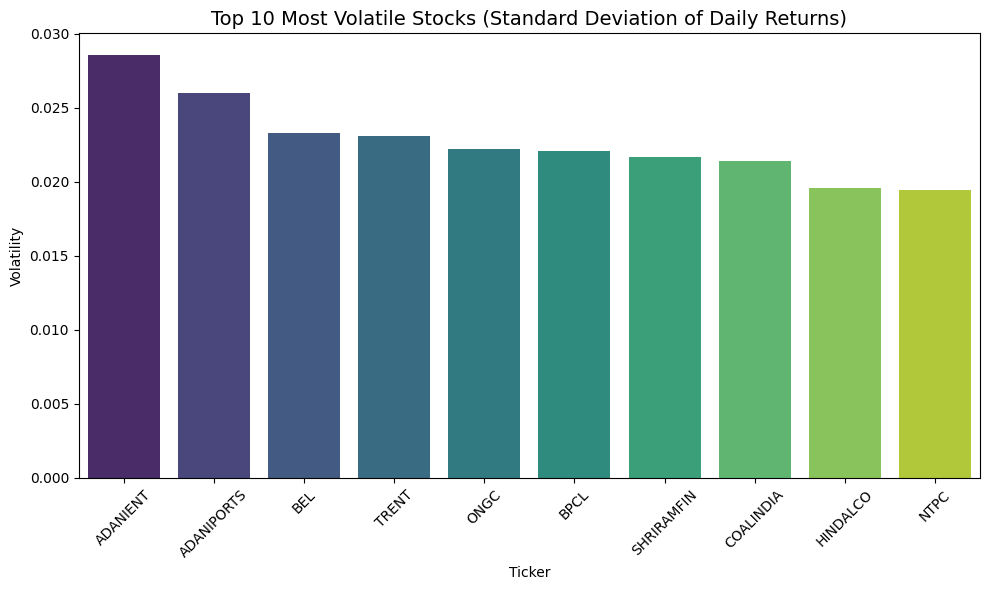

In [ ]:
# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_volatility_df, x='Ticker', y='Volatility', palette='viridis')
plt.title("Top 10 Most Volatile Stocks (Standard Deviation of Daily Returns)", fontsize=14)
plt.xlabel("Ticker")
plt.ylabel("Volatility")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "Volatility_Top_10_BarChart.png"))
plt.show()

C:\Users\VENKAT\AppData\Local\Temp\ipykernel_12972\1631634800.py:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\VENKAT\AppData\Local\Temp\ipykernel_12972\1631634800.py:15: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "Cumulative_Return_Top_5_LineChart.png"))
e:\StockAnalysis\Project\pro\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


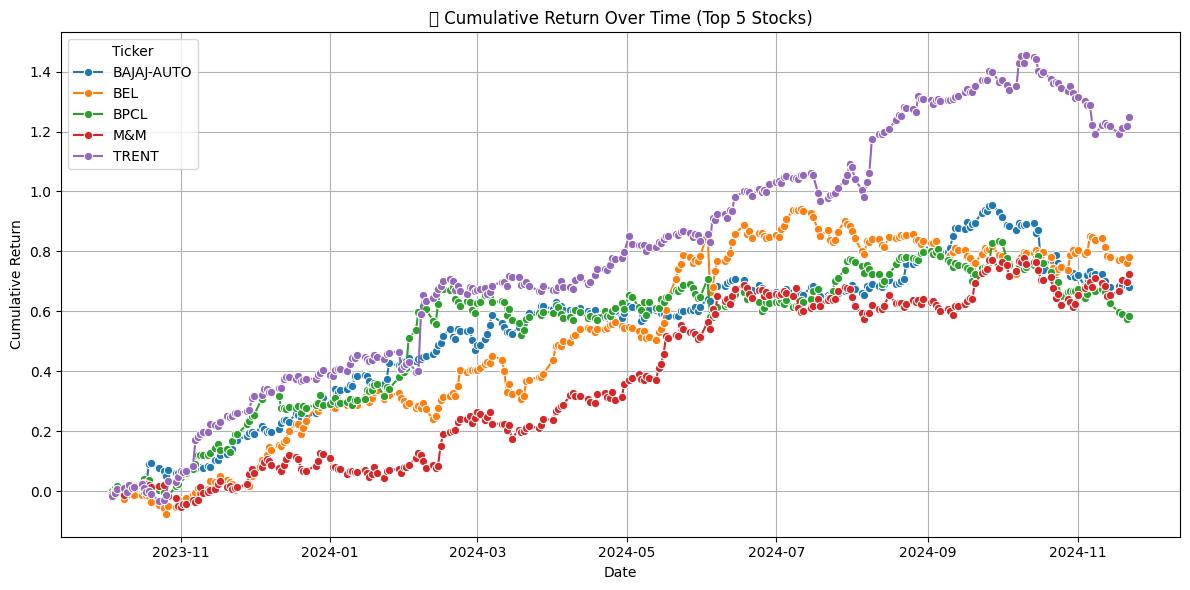

In [ ]:
# Plot line chart safely
plt.figure(figsize=(12, 6))

# Fix duplicates and reset index
top_5_df = top_5_df.drop_duplicates(subset=['Ticker', 'date']).reset_index(drop=True)

# Plot cumulative return
sns.lineplot(data=top_5_df, x='date', y='cumulative_return', hue='Ticker', marker='o')
plt.title("📈 Cumulative Return Over Time (Top 5 Stocks)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(title="Ticker")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "Cumulative_Return_Top_5_LineChart.png"))
plt.show()


In [22]:
# Calculate yearly return per stock
combined_df['yearly_return'] = combined_df.groupby('Ticker')['close'].transform(
    lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0]
)
yearly_return_df = combined_df.groupby('Ticker').last().reset_index()[['Ticker', 'yearly_return']]

In [ ]:
# Load Sector Data
sector_df = pd.read_csv(r"E:\StockAnalysis\Sector_data-Sheet1.csv")
display(sector_df)

,COMPANY,sector,Symbol
0,ADANI ENTERPRISES,MISCELLANEOUS,ADANI ENTERPRISES: ADANIGREEN
1,ADANI PORTS & SEZ,MISCELLANEOUS,ADANI PORTS & SEZ: ADANIPORTS
2,APOLLO HOSPITALS,MISCELLANEOUS,APOLLO HOSPITALS: APOLLOHOSP
3,ASIAN PAINTS,PAINTS,ASIAN PAINTS: ASIANPAINT
4,AXIS BANK,BANKING,AXIS BANK: AXISBANK
5,BAJAJ AUTO,AUTOMOBILES,BAJAJ AUTO: BAJAJ-AUTO
6,BAJAJ FINANCE,FINANCE,BAJAJ FINANCE: BAJFINANCE
7,BAJAJ FINSERV,FINANCE,BAJAJ FINSERV: BAJAJFINSV
8,BHARAT ELECTRONICS,DEFENCE,BHARAT ELECTRONICS: BEL
9,BHARTI AIRTEL,TELECOM,BHARTI AIRTEL: AIRTEL


In [29]:
# Handle cases like "INFOSYS: INFY" in Symbol column
sector_df[['Company', 'Symbol']] = sector_df['Symbol'].str.split(':', expand=True)
sector_df['Symbol'] = sector_df['Symbol'].str.strip()


In [ ]:
# Merge sector info
merged_df = pd.merge(yearly_return_df, sector_df, left_on='Ticker', right_on='Symbol', how='left')

In [ ]:
# Group by sector and compute average return
sector_performance_df = merged_df.groupby('sector')['yearly_return'].mean().reset_index()
sector_performance_df.sort_values(by='yearly_return', ascending=False, inplace=True)

In [ ]:
# Save results
output_dir = r"E:\StockAnalysis\Project\analysis_results_new"
os.makedirs(output_dir, exist_ok=True)
sector_performance_df.to_csv(os.path.join(output_dir, "Sector_Performance.csv"), index=False)
sector1 = pd.read_csv(r"E:\StockAnalysis\Project\analysis_results_new\Sector_Performance.csv")
display(sector1)

,sector,yearly_return
0,RETAILING,1.133054
1,DEFENCE,1.017601
2,POWER,0.601841
3,AUTOMOBILES,0.545265
4,MINING,0.418465
5,SOFTWARE,0.382760
6,CEMENT,0.369709
7,ENERGY,0.365648
8,MISCELLANEOUS,0.361031
9,ALUMINIUM,0.358683


C:\Users\VENKAT\AppData\Local\Temp\ipykernel_12972\2994940280.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sector_performance_df, x='sector', y='yearly_return', palette='tab10')
C:\Users\VENKAT\AppData\Local\Temp\ipykernel_12972\2994940280.py:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\VENKAT\AppData\Local\Temp\ipykernel_12972\2994940280.py:9: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "Sector_Performance_BarChart.png"))
e:\StockAnalysis\Project\pro\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


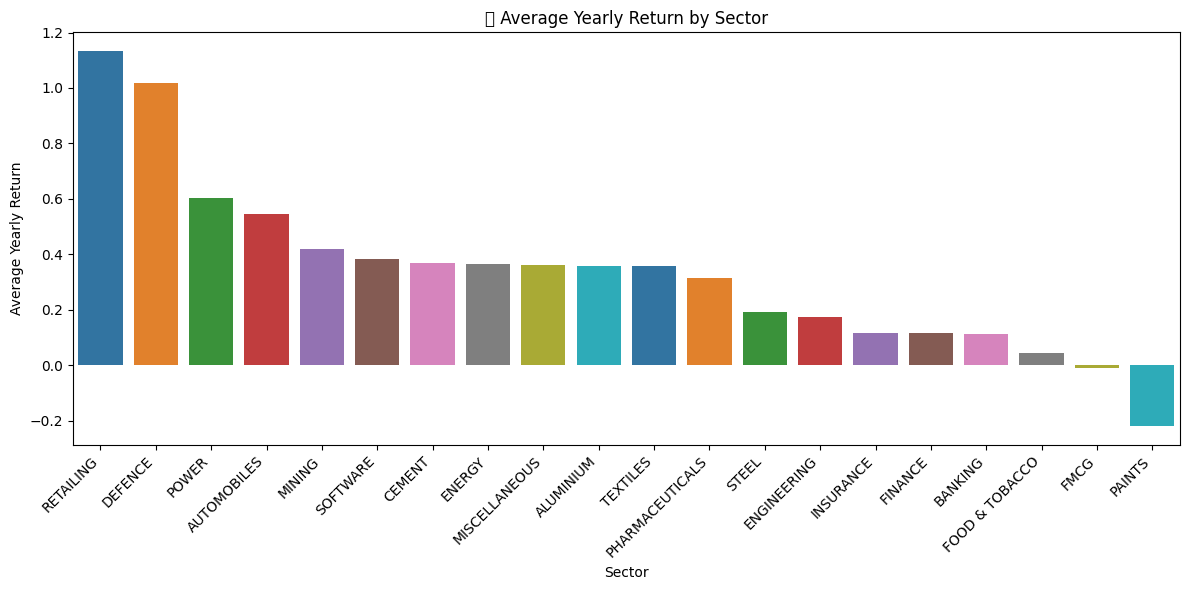

In [ ]:
# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=sector_performance_df, x='sector', y='yearly_return', palette='tab10')
plt.title("📊 Average Yearly Return by Sector")
plt.xlabel("Sector")
plt.ylabel("Average Yearly Return")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "Sector_Performance_BarChart.png"))
plt.show()

In [ ]:
# Extract 'date' and 'close' for each stock into one DataFrame
close_data = []

for file in csv_files:
    df = pd.read_csv(file)
    df['date'] = pd.to_datetime(df['date'])
    ticker = os.path.basename(file).replace(".csv", "")
    df = df[['date', 'close']].rename(columns={'close': ticker})
    close_data.append(df)

In [ ]:
# Merge all close prices on 'date'
merged_df = close_data[0]
for df in close_data[1:]:
    merged_df = pd.merge(merged_df, df, on='date', how='outer')

merged_df.sort_values(by='date', inplace=True)
merged_df.set_index('date', inplace=True)

In [ ]:
# Calculate percentage daily returns
daily_returns = merged_df.pct_change()

In [ ]:
# Correlation matrix
correlation_matrix = daily_returns.corr()

In [ ]:
# Save correlation matrix as CSV
output_dir = r"E:\StockAnalysis\Project\analysis_results_new"
os.makedirs(output_dir, exist_ok=True)
correlation_matrix.to_csv(os.path.join(output_dir, "Stock_Correlation_Matrix.csv"))
correlation = pd.read_csv(r"E:\StockAnalysis\Project\analysis_results_new\Stock_Correlation_Matrix.csv")
display(correlation)

,Unnamed: 0,ADANIENT,ADANIPORTS,APOLLOHOSP,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJAJFINSV,BAJFINANCE,BEL,...,SUNPHARMA,TATACONSUM,TATAMOTORS,TATASTEEL,TCS,TECHM,TITAN,TRENT,ULTRACEMCO,WIPRO
0,ADANIENT,1.000000,0.874233,0.136501,0.291583,0.297736,0.201871,0.356547,0.336031,0.522680,...,0.166256,0.203847,0.324071,0.423563,0.115790,0.141677,0.283281,0.190412,0.361152,0.224003
1,ADANIPORTS,0.874233,1.000000,0.168902,0.274045,0.380514,0.204456,0.398041,0.398769,0.585672,...,0.215856,0.220655,0.339241,0.466043,0.132423,0.148034,0.296148,0.201076,0.402489,0.238986
2,APOLLOHOSP,0.136501,0.168902,1.000000,0.258055,0.179381,0.223900,0.249392,0.223142,0.224594,...,0.286227,0.096700,0.212357,0.254731,0.106846,0.169118,0.253361,0.089516,0.272951,0.223738
3,ASIANPAINT,0.291583,0.274045,0.258055,1.000000,0.126055,0.167650,0.248090,0.296922,0.156953,...,0.202262,0.244278,0.105847,0.287050,0.166699,0.162959,0.307404,0.223094,0.280647,0.140642
4,AXISBANK,0.297736,0.380514,0.179381,0.126055,1.000000,0.198477,0.393683,0.354079,0.330512,...,0.143991,0.139747,0.232145,0.370957,0.094669,0.136469,0.145931,0.199748,0.397024,0.207802
5,BAJAJ-AUTO,0.201871,0.204456,0.223900,0.167650,0.198477,1.000000,0.237654,0.178554,0.233430,...,0.149957,0.185135,0.294698,0.283691,0.017591,0.037877,0.201060,0.223399,0.263342,0.102492
6,BAJAJFINSV,0.356547,0.398041,0.249392,0.248090,0.393683,0.237654,1.000000,0.748723,0.346261,...,0.213243,0.304497,0.280169,0.456570,0.234842,0.204276,0.329527,0.201133,0.463107,0.306650
7,BAJFINANCE,0.336031,0.398769,0.223142,0.296922,0.354079,0.178554,0.748723,1.000000,0.315822,...,0.137262,0.236369,0.212748,0.381616,0.174425,0.173360,0.269039,0.229188,0.434558,0.238516
8,BEL,0.522680,0.585672,0.224594,0.156953,0.330512,0.233430,0.346261,0.315822,1.000000,...,0.163531,0.175809,0.367173,0.520365,0.120758,0.222395,0.166767,0.263415,0.435501,0.255854
9,BHARTIARTL,0.282859,0.316537,0.236810,0.146953,0.238602,0.262054,0.257664,0.291641,0.309294,...,0.272227,0.248732,0.269331,0.305352,0.193183,0.272352,0.276037,0.247927,0.354121,0.259131


C:\Users\VENKAT\AppData\Local\Temp\ipykernel_12972\3644686653.py:5: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\VENKAT\AppData\Local\Temp\ipykernel_12972\3644686653.py:6: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "Stock_Correlation_Heatmap.png"))
e:\StockAnalysis\Project\pro\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


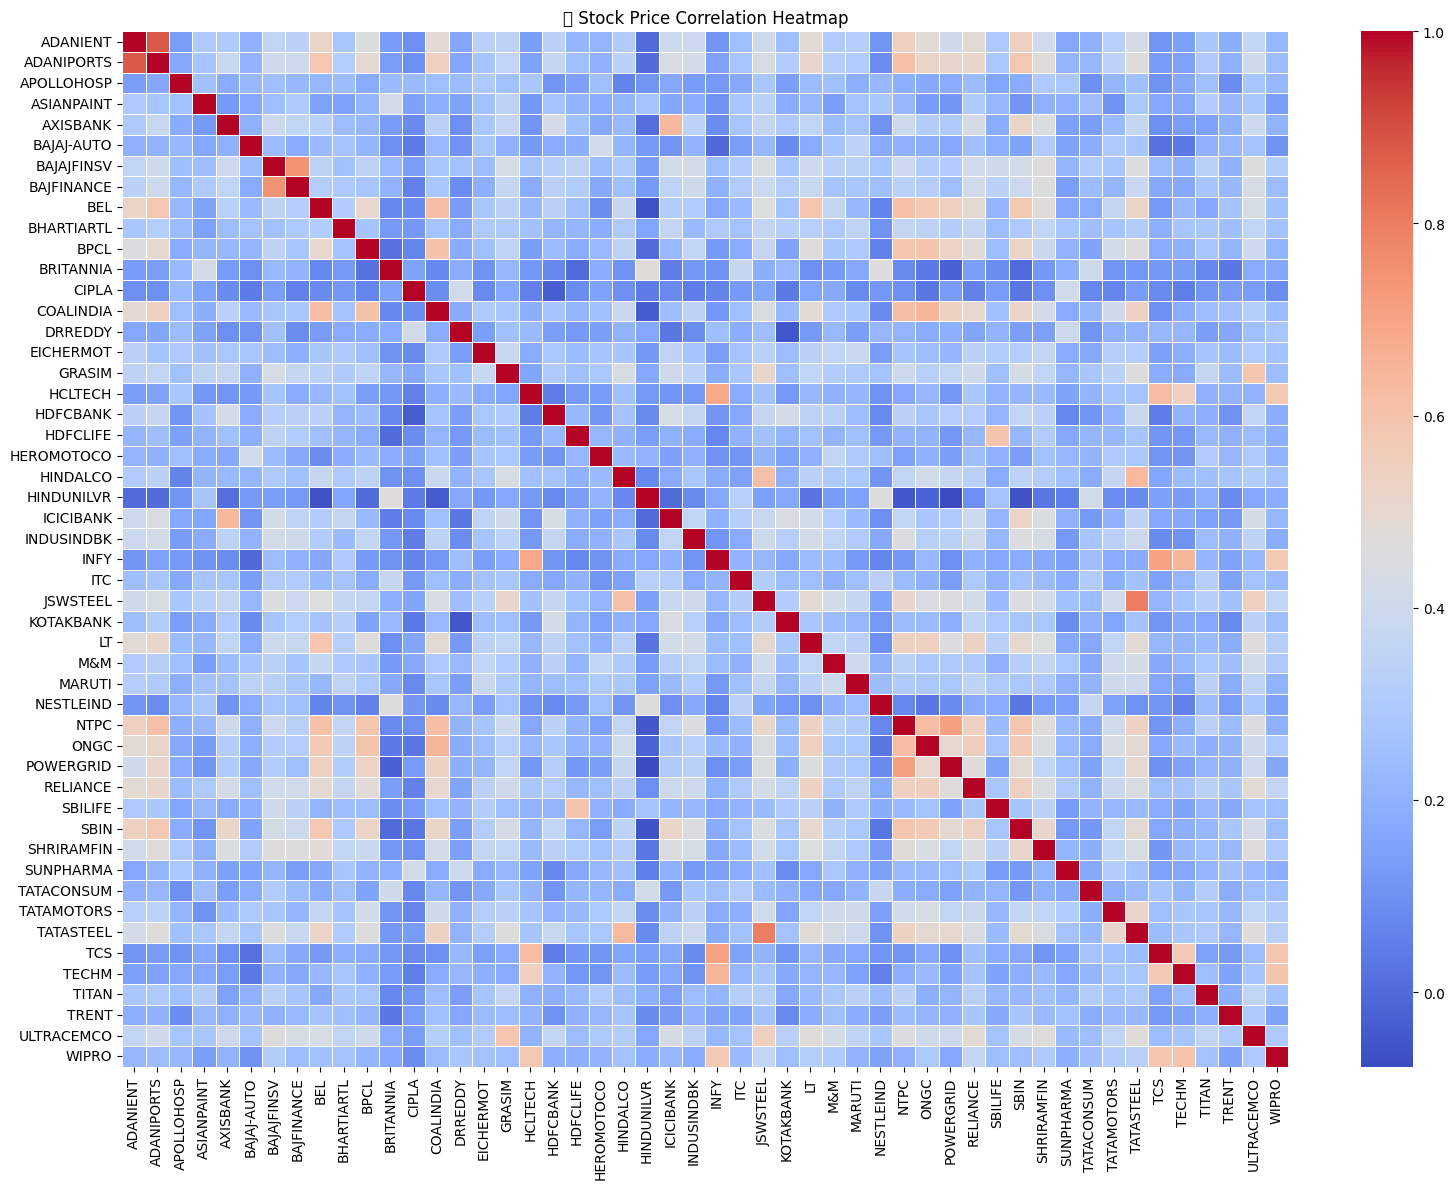

In [ ]:
# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("📊 Stock Price Correlation Heatmap")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "Stock_Correlation_Heatmap.png"))
plt.show()

In [ ]:
# Load and combine all files
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    df['Ticker'] = os.path.basename(file).replace(".csv", "")
    df['date'] = pd.to_datetime(df['date'])
    dataframes.append(df)

In [51]:
combined_df = pd.concat(dataframes)
combined_df.sort_values(by=['Ticker', 'date'], inplace=True)


In [ ]:
# Add month column and calculate monthly returns
combined_df['month'] = combined_df['date'].dt.to_period('M')
monthly = combined_df.groupby(['Ticker', 'month'])['close'].agg(['first', 'last']).reset_index()
monthly['monthly_return'] = (monthly['last'] - monthly['first']) / monthly['first']

In [ ]:
# Extract top 5 gainers and losers for each month
monthly_gainers_losers = []

for month in monthly['month'].unique():
    month_data = monthly[monthly['month'] == month].copy()
    top_5 = month_data.nlargest(5, 'monthly_return')
    bottom_5 = month_data.nsmallest(5, 'monthly_return')
    
    top_5['Rank'] = 'Top Gainers'
    bottom_5['Rank'] = 'Top Losers'
    combined = pd.concat([top_5, bottom_5])
    combined['Month'] = month.strftime('%Y-%m')
    monthly_gainers_losers.append(combined)

result_df = pd.concat(monthly_gainers_losers)
result_df = result_df[['Month', 'Ticker', 'monthly_return', 'Rank']]


In [ ]:
# Save to CSV
result_df.to_csv(os.path.join(output_dir, "Monthly_Top_Gainers_Losers.csv"), index=False)
gl = pd.read_csv(r"E:\StockAnalysis\Project\analysis_results_new\Monthly_Top_Gainers_Losers.csv")
display(gl)

,Month,Ticker,monthly_return,Rank
0,2023-10,NESTLEIND,0.086022,Top Gainers
1,2023-10,COALINDIA,0.076567,Top Gainers
2,2023-10,BAJAJ-AUTO,0.059325,Top Gainers
3,2023-10,SBILIFE,0.058339,Top Gainers
4,2023-10,TRENT,0.046428,Top Gainers
...,...,...,...,...
135,2024-11,ADANIENT,-0.244618,Top Losers
136,2024-11,ADANIPORTS,-0.184775,Top Losers
137,2024-11,ASIANPAINT,-0.159073,Top Losers
138,2024-11,BRITANNIA,-0.148374,Top Losers


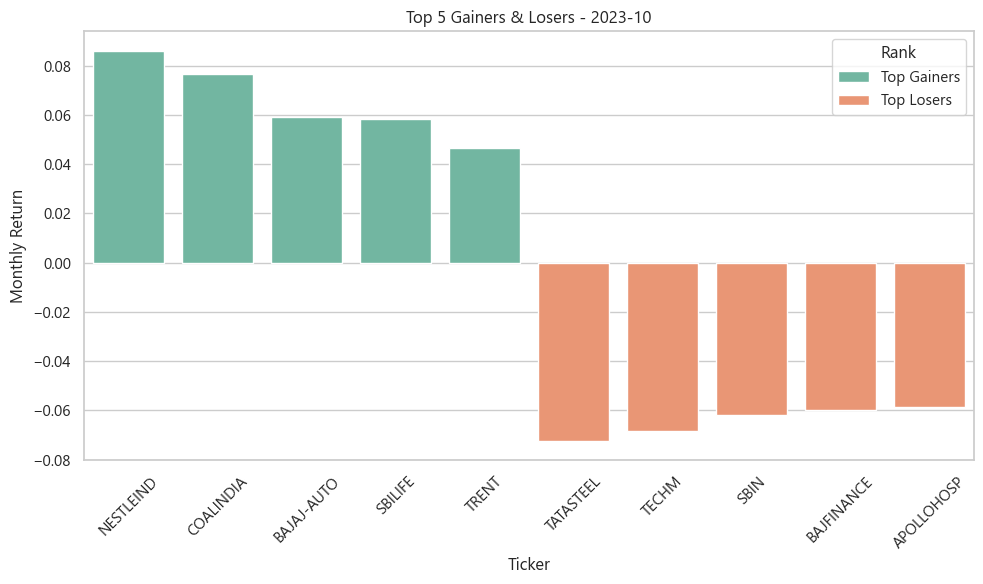

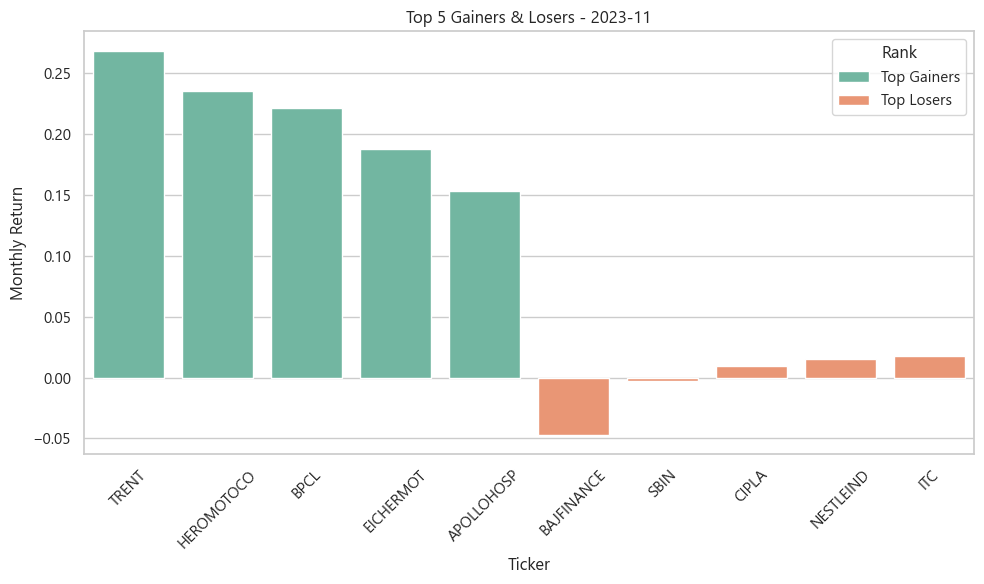

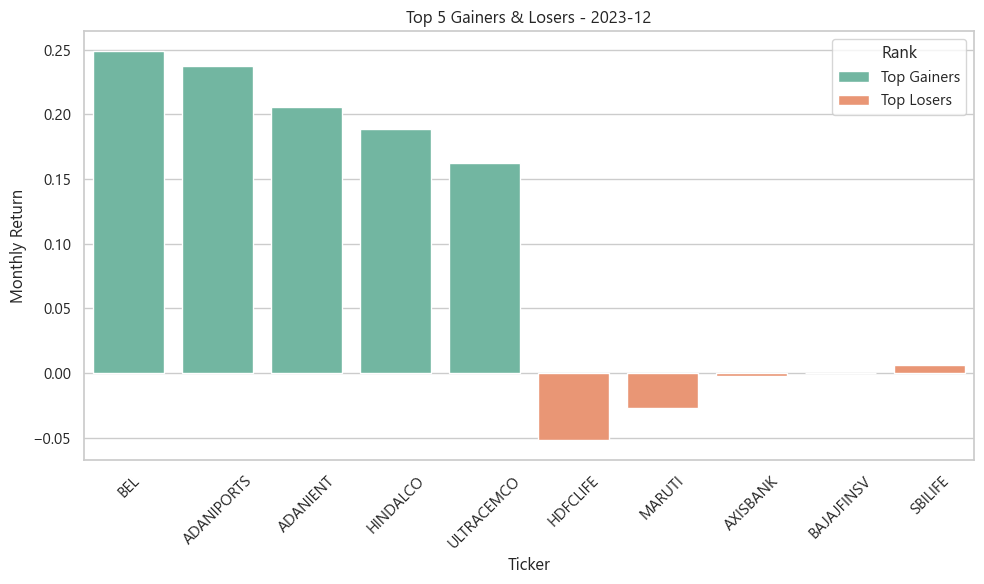

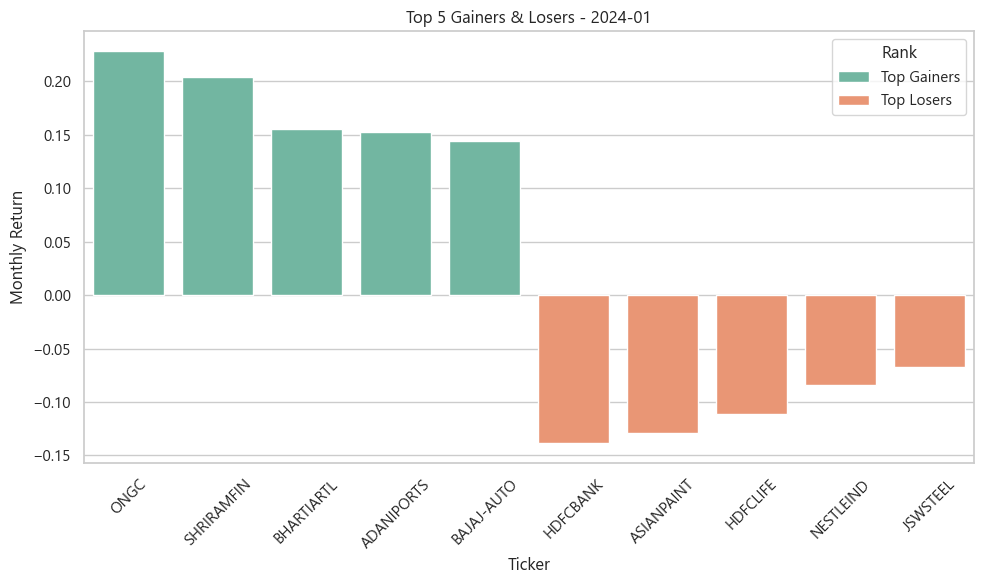

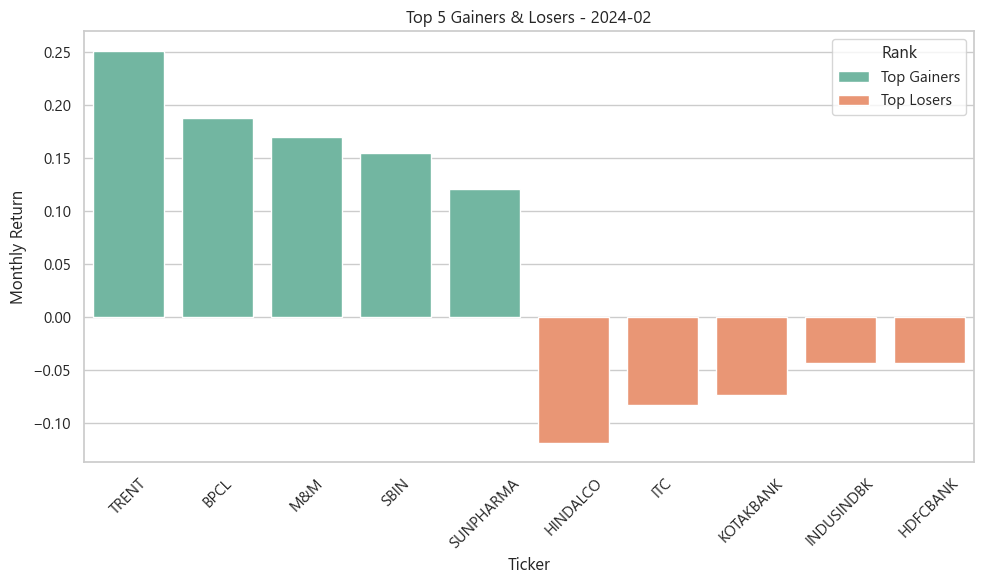

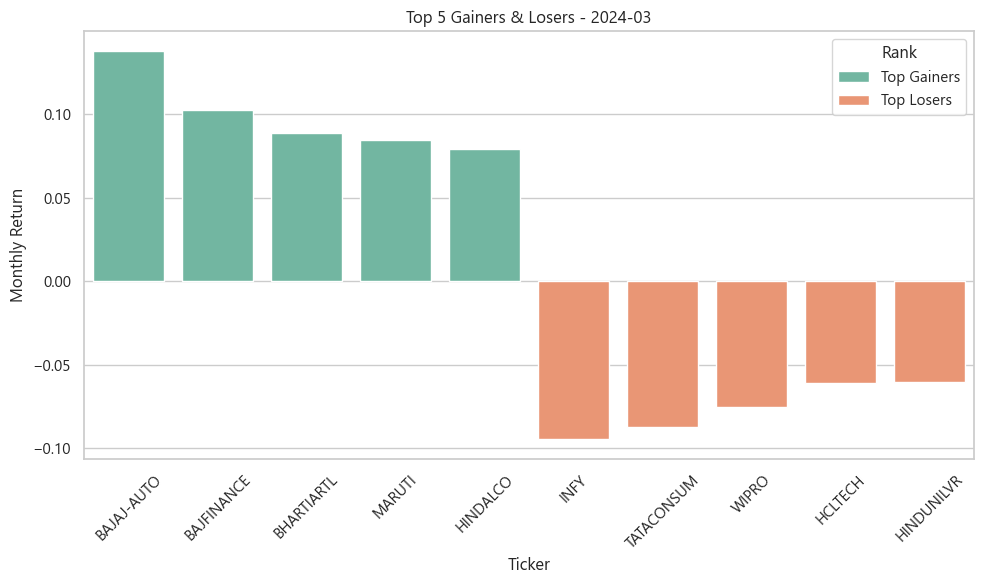

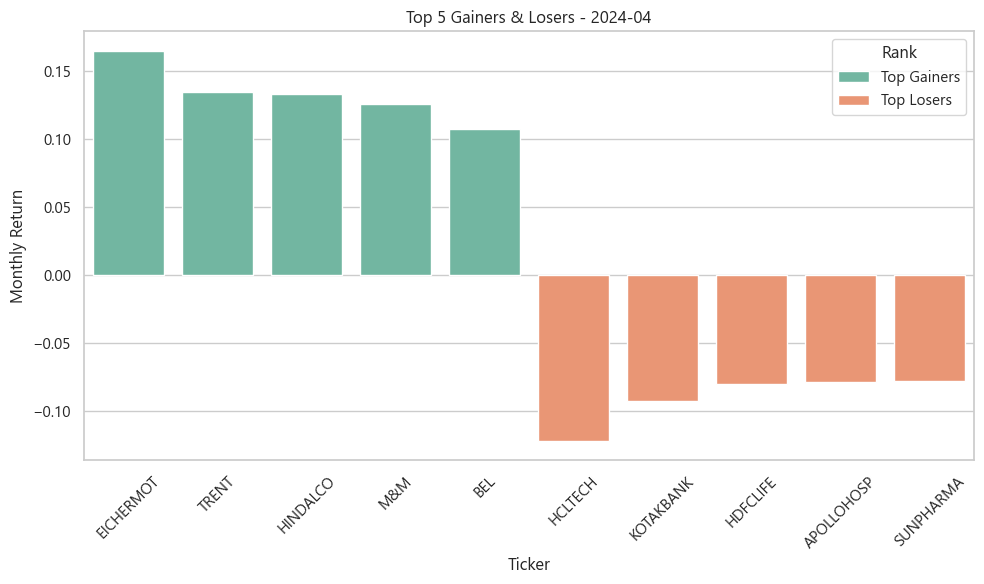

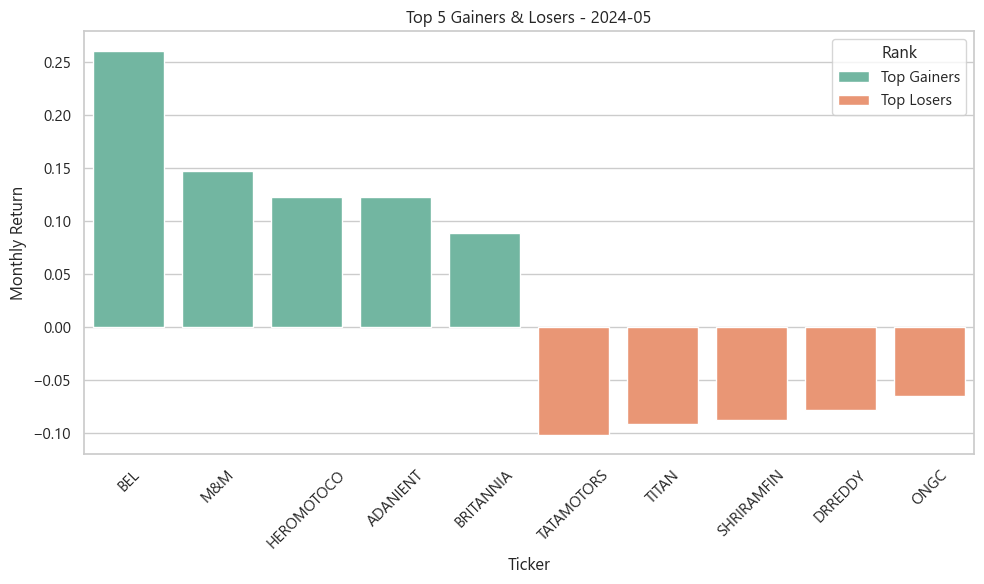

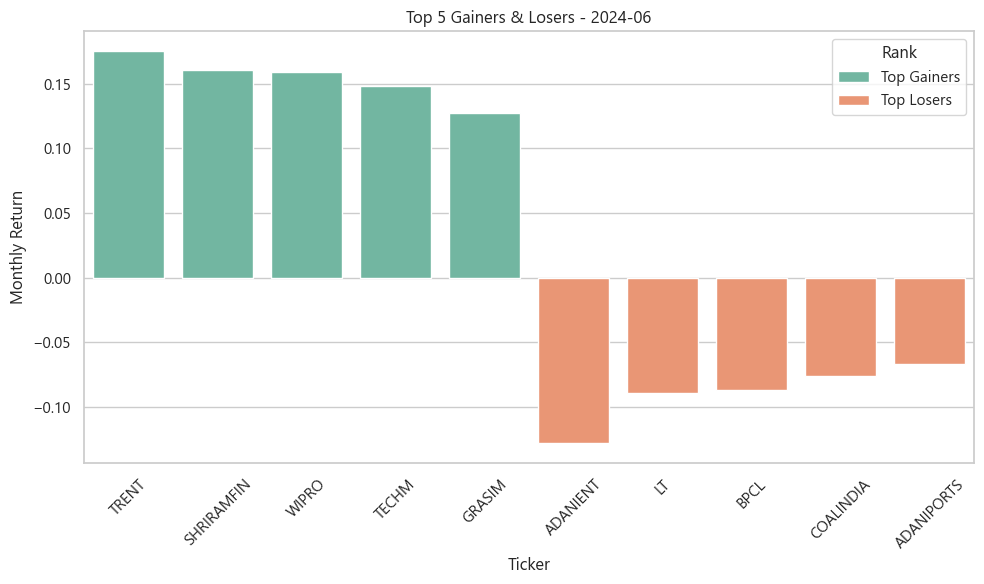

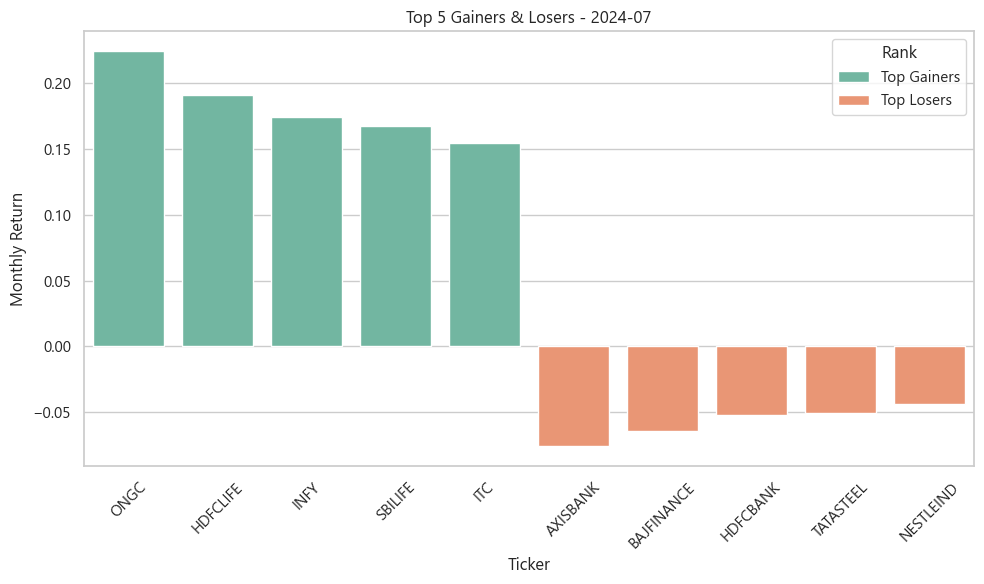

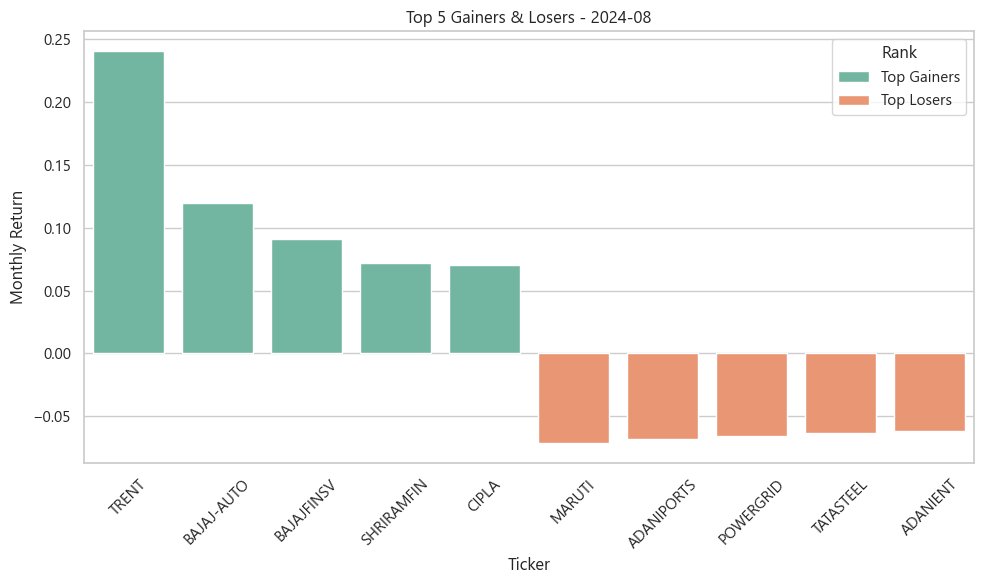

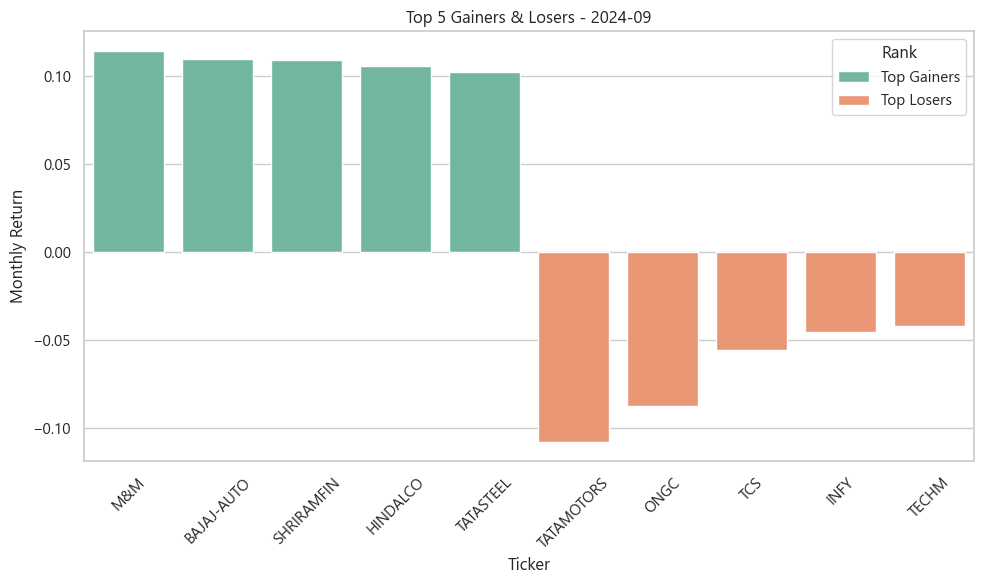

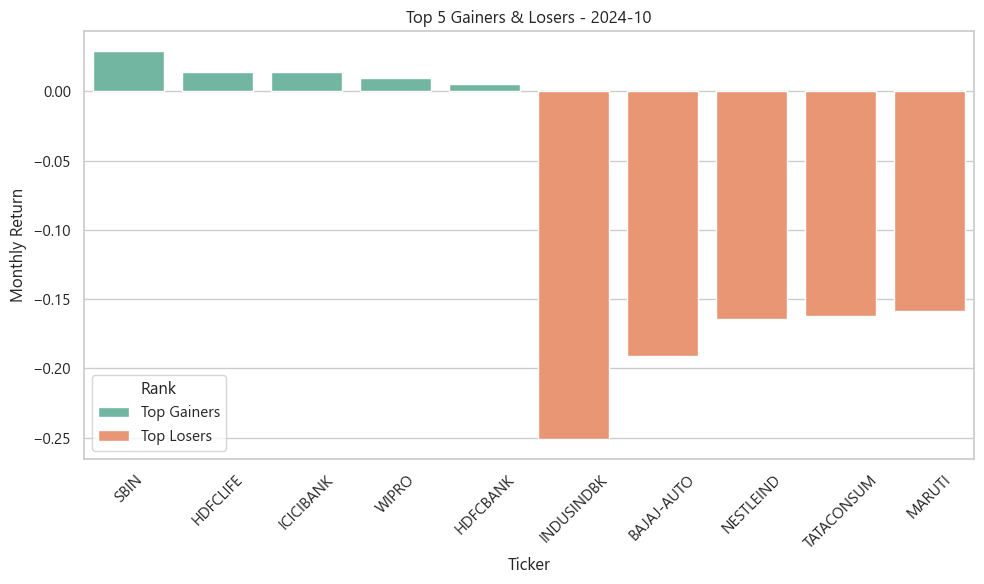

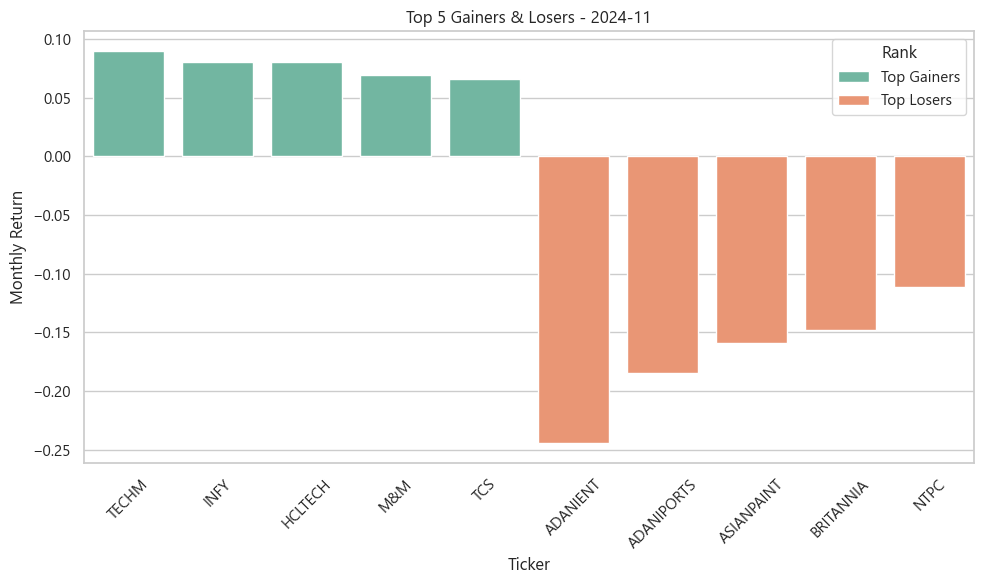

In [ ]:
# Plot charts
unique_months = result_df['Month'].unique()

for month in unique_months:
    month_df = result_df[result_df['Month'] == month]
    plt.figure(figsize=(10, 6))
    sns.barplot(data=month_df, x='Ticker', y='monthly_return', hue='Rank', palette='Set2')
    plt.title(f"Top 5 Gainers & Losers - {month}")
    plt.rcParams['font.family'] = 'Segoe UI Emoji'
    plt.title(f"📊 Top 5 Gainers & Losers - {month}")
    plt.title(f"Top 5 Gainers & Losers - {month}")
    plt.ylabel("Monthly Return")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"Top_5_Gainers_Losers_{month}.png"))

In [64]:
import mysql.connector

In [66]:
# Connect to MySQL
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Venkat123",
    database="StockAnalysis",
    autocommit=True
)

In [ ]:
# CSV file paths
csv_files = {
    "cumulative_return_top_5": r"E:\StockAnalysis\Project\analysis_results\Cumulative_Return_Top_5.csv",
    "sector_performance": r"E:\StockAnalysis\Project\analysis_results\Sector_Performance.csv",
    "top_10_most_volatile_stocks": r"E:\StockAnalysis\Project\analysis_results_new\Top_10_Most_Volatile_Stocks.csv",
    "stock_correlation_matrix": r"E:\StockAnalysis\Project\analysis_results_new\Stock_Correlation_Matrix.csv",
    "monthly_top_gainers_losers": r"E:\StockAnalysis\Project\analysis_results_new\Monthly_Top_Gainers_Losers.csv"
}

# Create connection engine
engine = create_engine(f"mysql+mysqlconnector://{"root"}:{"Venkat123"}@{"localhost"}/{"StockAnalysis"}")

In [ ]:
# Insert each CSV into MySQL table
for table_name, file_path in csv_files.items():
    df = pd.read_csv(file_path)
    df.to_sql(name=table_name, con=engine, if_exists='replace', index=False)
    print(f"✅ Inserted '{table_name}' into MySQL.")

print("All CSV files inserted into MySQL successfully.")

✅ Inserted 'cumulative_return_top_5' into MySQL.
✅ Inserted 'sector_performance' into MySQL.
✅ Inserted 'top_10_most_volatile_stocks' into MySQL.
✅ Inserted 'stock_correlation_matrix' into MySQL.
✅ Inserted 'monthly_top_gainers_losers' into MySQL.
🎉 All CSV files inserted into MySQL successfully.
